              precision    recall  f1-score   support

           0      0.964     0.999     0.982      4205
           1      0.250     0.006     0.013       156

    accuracy                          0.964      4361
   macro avg      0.607     0.503     0.497      4361
weighted avg      0.939     0.964     0.947      4361



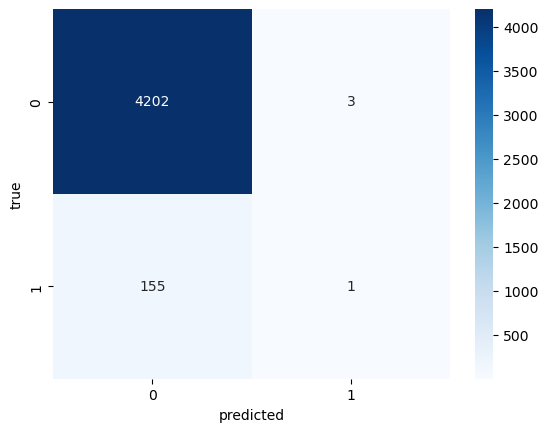

In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from utils import col_map
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# create dataframe with appropriate names
df = pd.read_csv("data/brno_nehody.csv")
df.rename(columns=col_map, inplace=True)

# create target feature that represents if accident
# was severe, defined as 1 if person died or got serious injury
df["severe"] = ((df["fatalities"] > 0) | (df["serious_injuries"] > 0)).astype(int)
df["severe"].sum()

# select features used for classification
features = [
    "road_surface_condition",   # p16: 1=dry,3=wet,...
    "weather_conditions",       # p18
    "visibility",               # p19
    "road_category",            # p36 motorway/1/2/...
    "road_division",            # p21
    "number_vehicles",          # p34
    "time",                     # p2b -> hour/min 
    # "date",                   # p2a
    "place_of_accident",        # p35
    "vehicle_type",             # p44
    "year",                     # created feature
    "month",                    # created feature
    "day"                       # created feature
]

# delete date feature, extract separate of them to DF
df["year"] = df["date"].str.split("-").str[0].astype(int)
df["month"] = df["date"].str.split("-").str[1].astype(int)
df["day"] = df["date"].str.split("-").str[2].astype(int)

df.drop("date", axis=1, inplace=True)

df["year"].isna().any()

# Get feature matrix X and target feature array
X = df[features].copy()
y = df["severe"].copy()

# Separate features for numerical and categorical
numeric_feats = ["number_vehicles", "time", "year", "month", "day"]
categorical_feats = [f for f in features if f not in numeric_feats]

# Create processing pipelines for numerical features
# and for categorical ones

# change all NaN to mean of this column
# scale numerical features 
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

# change all NaN to constant '-missing-'
# change all categories to one hot encoder
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_feats),
        ("cat", categorical_transformer, categorical_feats)
    ]
)

# apply all pipelines
clf = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
)

# split data to testing and training 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify поможет при дисбалансе
)

# fit data and make new predictions on test set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# evaluate performance of the model
print(classification_report(y_test, y_pred, digits=3))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

# Results:
# - Built a RandomForestClassifier to predict whether an accident is severe 
#   (fatality or serious injury) based on road, weather, vehicle, and temporal features
# - Preprocessed numerical features with mean imputation and scaling
# - Preprocessed categorical features with most frequent imputation and one-hot encoding
# - Split data into train/test sets with stratification to handle class imbalance
# - Evaluated model with classification report and confusion matrix
# Usage:
# - clf can now predict severity of new accidents
# - Useful for risk assessment, accident prevention


In [3]:
# create dataframe with appropriate names
df = pd.read_csv("data/brno_nehody.csv")
df.rename(columns=col_map, inplace=True)

df.head()

,id,road_category,road_number,date,time,accident_type,collision_type,fixed_obstacle_type,accident_character,responsibility,...,driver_category,driver_condition,external_influence_on_driver,locality_type,animal_type,drugs_at_driver,x,y,geom,geog
0,60040220005,0.0,1.0,2022-01-31,1615,1,4,0,1,1,...,4,1,1,2,-1,-1,-604517.819,-1162781.504,01010000208A150000CFF753A3CB7222C1DD2406811DBE...,0101000020E6100000F03BB8033A863040913ACBC3DC95...
1,60040220014,0.0,1.0,2022-02-21,2560,3,0,4,2,1,...,-1,-1,-1,1,-1,-1,-604153.462,-1162893.337,01010000208A15000096438BECF26F22C1CBA145568DBE...,0101000020E610000097E4C0798A873040825132A9C795...
2,60040220020,0.0,1.0,2022-04-21,405,1,4,0,1,1,...,3,2,1,2,-1,-1,-604493.308,-1162787.426,01010000208A1500000E2DB29D9A7222C104560E6D23BE...,0101000020E61000009BB32F7E50863040734B7CD0DB95...
3,60040220030,0.0,1.0,2022-05-25,1015,1,4,0,2,1,...,2,1,1,1,-1,-1,-603644.567,-1163072.147,01010000208A150000F2D24D22F96B22C1C1CAA12540BF...,0101000020E6100000A6C301996289304076A6678CA395...
4,60040220035,0.0,1.0,2022-06-06,2150,6,0,0,2,4,...,2,1,1,1,-1,-1,-591799.309,-1163846.206,01010000208A1500007D3F359E6E0F22C17F6ABC3446C2...,0101000020E61000001D826CFB06B33040FD51FB543796...
